In [1]:
from utils import (
    get_cifar10_data_loaders,
    compute_validation_accuracy_multi,
    NN_FC_CrossEntropy,
    train_one_epoch,
)

from fastprogress.fastprogress import master_bar

import torch
from torch import nn
from torchvision.utils import make_grid
from torchvision.models import resnet18

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [16]:
# Configuration parameters
data_path = "../data"
seed = 0
torch.manual_seed(seed)

# Hyperparameters (other built in to criterion and optimizer)
num_epochs = 3
batch_size = 128
valid_batch_size = 0

# Training device
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

Using 'cpu' device.


In [3]:
# Get data loaders
train_loader, valid_loader = get_cifar10_data_loaders(
    data_path, batch_size, valid_batch_size
)

train_loader.dataset.data.shape, valid_loader.dataset.data.shape, train_loader.dataset.classes

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3),
 (10000, 32, 32, 3),
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [4]:
# This is how I came up with the normalization values in utils
# tl, _ = get_cifar10_data_loaders(data_path, 0, 0)
# X, y = next(iter(tl))
# X.shape, y.shape
# torch.std_mean(X, dim=(0, 2, 3))

      frog      truck      truck       deer automobile automobile       bird      horse
      ship        cat       deer      horse      horse       bird      truck      truck
     truck        cat       bird       frog       deer        cat       frog       frog
      bird       frog        cat        dog       deer   airplane   airplane      truck
automobile        cat       deer   airplane        cat      horse        cat        cat
       dog       bird       bird      horse automobile automobile automobile       bird
      bird   airplane      truck        dog      horse      truck       bird       bird
       dog       bird       deer        cat automobile automobile       ship       bird


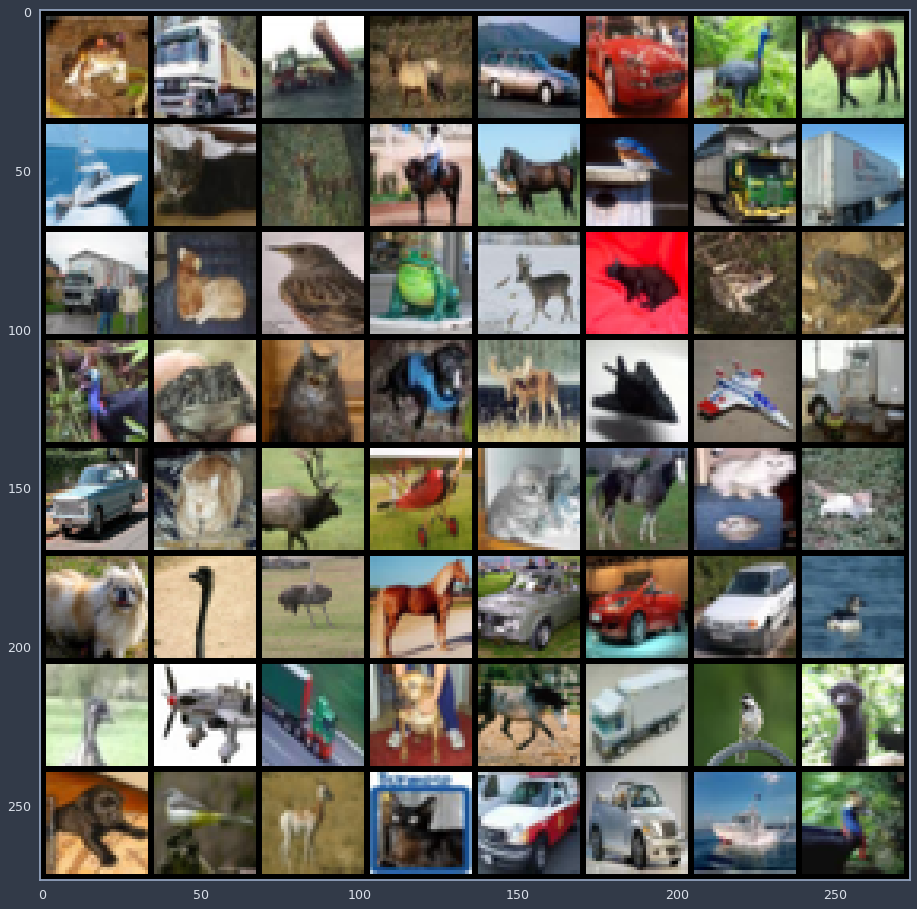

In [5]:
n = 64

# Grab a bunch of images and change the range to [0, 1]
images = torch.tensor(train_loader.dataset.data[:n] / 255)

# Create a grid of the images (make_grid expects (BxCxHxW))
image_grid = make_grid(images.permute(0, 3, 1, 2))

_, axis = plt.subplots(figsize=(16, 16))
axis.imshow(image_grid.permute(1, 2, 0))
axis.grid(None)

targets = train_loader.dataset.targets[:n]
classes = train_loader.dataset.classes

labels = [f"{classes[target]:>10}" for target in targets]

images_per_row = int(n ** 0.5)

for row in range(images_per_row):
    start_index = row * images_per_row
    print(" ".join(labels[start_index : start_index + images_per_row]))

In [17]:
# model = nn.Sequential(nn.Flatten(), nn.Linear(3 * 32 * 32, 10))

# nx = torch.prod(torch.tensor(train_loader.dataset.data.shape[1:]))
# ny = len(train_loader.dataset.classes)
# layer_sizes = (nx, 20, 20, ny)
# model = NN_FC_CrossEntropy(layer_sizes, torch.nn.Sigmoid).to(device)

model = resnet18(num_classes=10)
# model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
mb = master_bar(range(num_epochs))
compute_validation_accuracy_multi(valid_loader, model, criterion, device, mb, 0)
for epoch in mb:
    train_one_epoch(train_loader, model, criterion, optimizer, device, mb)
    loss, accuracy = compute_validation_accuracy_multi(
        valid_loader, model, criterion, device, mb, epoch + 1
    )

KeyboardInterrupt: 

In [9]:
correct = 0
total = 0

class_correct = [0] *len(classes)
class_total = [0] *len(classes)

model.eval()

with torch.no_grad():

    for images, targets in valid_loader:

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)

        predictions = outputs.argmax(dim=1, keepdim=True)
        
        comparisons = predictions.eq(targets.view_as(predictions))
        for comp, label in zip(comparisons, targets):
            class_correct[label] += comp.item()
            class_total[label] += 1

        total += targets.shape[0]
        correct += int(comparisons.double().sum().item())
        
accuracy = correct / total
print(f"Accuracy on validation set: {correct}/{total} = {accuracy*100:.2f}%")

for i, cls in enumerate(classes):
    ccorrect = class_correct[i]
    ctotal = class_total[i]
    caccuracy = ccorrect / ctotal
    print(f"  Accuracy on {cls:>10} class: {ccorrect}/{ctotal} = {caccuracy*100:.2f}%")

Accuracy on validation set: 6985/10000 = 69.85%
  Accuracy on   airplane class: 760/1000 = 76.00%
  Accuracy on automobile class: 780/1000 = 78.00%
  Accuracy on       bird class: 562/1000 = 56.20%
  Accuracy on        cat class: 469/1000 = 46.90%
  Accuracy on       deer class: 641/1000 = 64.10%
  Accuracy on        dog class: 754/1000 = 75.40%
  Accuracy on       frog class: 731/1000 = 73.10%
  Accuracy on      horse class: 726/1000 = 72.60%
  Accuracy on       ship class: 714/1000 = 71.40%
  Accuracy on      truck class: 848/1000 = 84.80%


In [10]:
from fastai.vision.all import untar_data, URLs, ImageDataLoaders, cnn_learner, xresnet18, accuracy
path = untar_data(URLs.CIFAR)
dls = ImageDataLoaders.from_folder(path, valid="test", bs=batch_size)
learn = cnn_learner(dls, xresnet18, metrics=accuracy)
learn.fine_tune(num_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,1.565648,1.324653,0.528700,00:18


epoch,train_loss,valid_loss,accuracy,time
0,1.291224,1.153435,0.586300,00:22
1,1.045940,0.965103,0.655400,00:18
2,0.918966,0.921674,0.673000,00:18


In [ ]:
learn.model